# Titanic Dataset - Program which uses Logistic Regression and SVM and analyzes their performance. Additional: XGBoost and DecisionTree  
   
   
    I tried to build a program which is focused on tuning the parameters of Logistic Regression and on SVM to achieve high accuracy on this dataset.
   
    Firstly, I imported the libraries needed to write the code and I loaded the two datasets:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_train = pd.read_csv("../input/titanic/train.csv")
data_train.head()
#data_train.shape #(891, 12)
#data_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


    The number of cells (the shape) of the train dataset is:

In [3]:
data_train.shape

(891, 12)

    Next, it is created the list of the features in this dataset to analyze the data in a easier way:

In [4]:
features = [col for col in data_train.columns]
print(features)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


    It is checked the type of the data of every column and the function creates a list which contains the object features:

In [5]:
def findObj(features):
    features_obj = []
    for feat in features:
        if data_train[feat].dtype == "object":
            features_obj.append(feat)
    return features_obj
findObj(features)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

    After creating the list of features, the function where_null creates a list which contains the features where there exist null values:

In [6]:
def where_null(data_train, features):
    features_where_null = []
    for feat in features:
        if data_train[feat].isnull().sum() >= 1:
            features_where_null.append(feat)
    return features_where_null
problem_feat = where_null(data_train, features)
problem_feat

['Age', 'Cabin', 'Embarked']

    The next two blocks of code calculate how many null values are in every feature from problem_feat list and how how many values are left:

In [7]:
for feat in problem_feat:
    print(feat + " " + str(data_train[feat].isnull().sum()))

Age 177
Cabin 687
Embarked 2


In [8]:
for feat in problem_feat:
    print(feat + " " + str(891 - data_train[feat].isnull().sum()))

Age 714
Cabin 204
Embarked 889


    We notice that 'Embarked' and 'Age' has some useful information. Comparing them to 'Cabin', these columns contain far more information. But we should see how useful are they regarding to predicting the outcome (we can use mutual information or analysing the data based on percentile). For example:

Text(0, 0.5, 'Number')

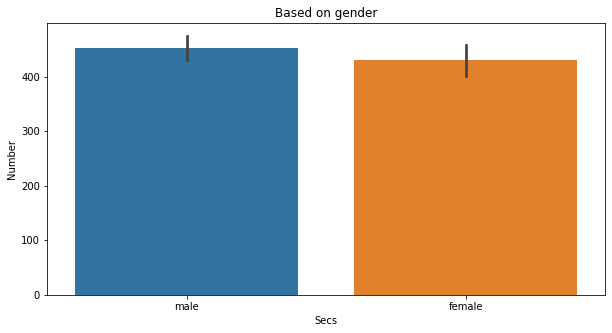

In [9]:
plt.figure(figsize = (10, 5))
plt.title("Based on gender")
sns.barplot(x = data_train['Sex'], y = data_train.index)
plt.xlabel("Secs")
plt.ylabel("Number")

We observe that there are slightly more men than women so it is balanced.

<AxesSubplot:xlabel='Pclass'>

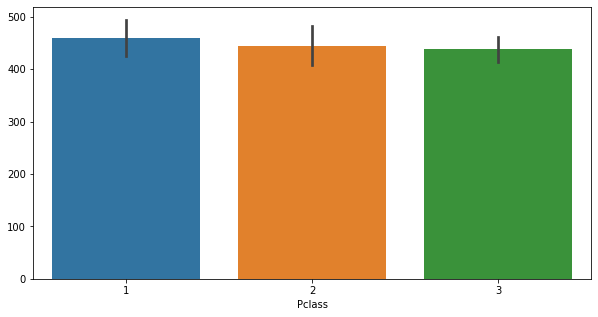

In [10]:
plt.figure(figsize = (10, 5), num = "Based on Class")
sns.barplot(x = data_train['Pclass'], y = data_train.index)

    Classes are balanced; So now we will use mutual information to decide which data is more important regarding our model. When working with this data, it is important to separate the output('Survived') column to work with our data and to factorize the object type data because mutual information behaves differently when working with discrete features or continuos features

In [11]:
X = data_train.copy()
y = X.pop("Survived")

    We observe that Ticket and Cabin are not important features, so we drop them completely:

In [12]:
X = X.drop(['Ticket', 'Cabin'], axis = 'columns')

    "Age" has null values in it. So to get rid of them, they become the mean of the numeric values:

In [13]:
X['Age'].fillna(X['Age'].mean(), inplace=True)

In [14]:
def transformFare(X):
    result = map(int, X['Fare'])
    result = pd.Series(result)
    #print(result)
    X.drop("Fare", axis = 'columns', inplace = True)
    #X.head()
    X.insert(8, "Fare", result)
    
def transformAge(X):
    result = map(int, X['Age'])
    result = pd.Series(result)
    X.drop("Age", axis = "columns", inplace = True)
    X.insert(4, "Age", result)
    
transformFare(X)
transformAge(X)
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Fare
0,1,3,"Braund, Mr. Owen Harris",male,22,1,0,S,7
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,C,71
2,3,3,"Heikkinen, Miss. Laina",female,26,0,0,S,7
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,S,53
4,5,3,"Allen, Mr. William Henry",male,35,0,0,S,8


    After preprocessing the data, the dataset is ready to be used. We begin by implementing a mutual information function to check which features are most important:

In [15]:
for cols in X.select_dtypes("object"):
    X[cols], _ = X[cols].factorize()
discrete_features = X.dtypes == int
discrete_features

PassengerId    True
Pclass         True
Name           True
Sex            True
Age            True
SibSp          True
Parch          True
Embarked       True
Fare           True
dtype: bool

In [16]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Sex            0.104697
Pclass         0.084907
Parch          0.077359
Embarked       0.029391
SibSp          0.006641
Fare           0.004372
PassengerId    0.000000
Name           0.000000
Age            0.000000
Name: MI Scores, dtype: float64

    We observe that sex influences the most the probability of survival. So we decide that we can use a linear model, Logistic Regression. But firstly, let's split the data into train and test:

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

    On the first try, let's see how accurate this model is:

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 100000).fit(X_train, y_train)
model.score(X_test, y_test)

0.7982062780269058

    It is not bad, but it can surely be improved.

In [19]:
from sklearn.linear_model import LogisticRegression
def logis(X_train, y_train, X_test, y_test):
    for c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]:
        logmodel = LogisticRegression(C = c, max_iter = 100000).fit(X_train, y_train)
        print("The score for training {} is :{:.3f}".format(c, logmodel.score(X_train, y_train)))
        print("The score for testing {} is :{:.3f}\n".format(c, logmodel.score(X_test, y_test)))
    
logis(X_train, y_train, X_test, y_test)

The score for training 0.0001 is :0.651
The score for testing 0.0001 is :0.695

The score for training 0.001 is :0.675
The score for testing 0.001 is :0.709

The score for training 0.01 is :0.732
The score for testing 0.01 is :0.771

The score for training 0.1 is :0.805
The score for testing 0.1 is :0.803

The score for training 1 is :0.804
The score for testing 1 is :0.798

The score for training 10 is :0.804
The score for testing 10 is :0.798

The score for training 100 is :0.804
The score for testing 100 is :0.798

The score for training 1000 is :0.804
The score for testing 1000 is :0.798

The score for training 10000 is :0.804
The score for testing 10000 is :0.798

The score for training 100000 is :0.804
The score for testing 100000 is :0.798



    The best coefficients are the ones above 0.1 and the best C value is 0.1 . It is not a model that performs poorly, but it can surely be improved. We could have used another methods for testing our model, like Leave One Out or shuffling the data, but it does not matter, since we have another data frame for testing the algorithm. But we shall see after testing it on the final dataset

    We can also use Logistic Regression with Cross Validation function from sklearn_linear model and try some Cross Validation techniques

In [20]:
from sklearn.linear_model import LogisticRegressionCV
#1.ShuffleSplit
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(test_size = .5, train_size = .5, n_splits = 10)
logr = LogisticRegressionCV(max_iter = 100000, cv = cv)
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

0.7982062780269058

In [21]:
#2.LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
cvo = LeaveOneOut()
s = cross_val_score(LogisticRegression(C = 0.1, max_iter = 100000), X_train, y_train, cv = cvo)
s.mean()

0.7994011976047904

In [22]:
#3.KFold
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 3, shuffle = True, random_state = 0)
result = cross_val_score(LogisticRegression(C = 0.1, max_iter = 100000), X_train, y_train, cv = kfold)
result.mean()

0.7978561521162417

    Another model we can use is a SVM. It can be built in different methods by adjusting parameters (especially kernel functions)

In [23]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC())])
 
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8071748878923767

    We observe that even if the svm model is a basic one, it performs better than Logistic Regression. Now, we try to make one even performant. 

In [24]:
svmfunc = SVC(gamma = "auto", class_weight = "balanced")
pipeline = Pipeline([("scaler", StandardScaler()),("svm", svmfunc)])
 
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8161434977578476

    We observe that after setting class weight to balanced, we obtain a better accuracy. That is because it adjusts the weights automatically, so it is less restrictive. Next, we try different kernels:

In [25]:
kernels = ["linear", "poly", "rbf", "sigmoid"]

listofscores = []
for kernel in kernels:
    svmfunc = SVC(gamma = "auto", kernel = kernel, class_weight = "balanced")
    pipeline = Pipeline([("scaler", StandardScaler()),("svm", svmfunc)])
 
    pipeline.fit(X_train, y_train)
    listofscores.append(pipeline.score(X_test, y_test))
listofscores

[0.7802690582959642,
 0.8116591928251121,
 0.8161434977578476,
 0.7130044843049327]

    The best results were for 1) rbf and 2)poly. We will stick with rbf.

    But there are more classification methods for support vector machines. (LinearSVC, NuSVC)

In [26]:
from sklearn.svm import NuSVC
kernels = ["linear", "poly", "rbf", "sigmoid"]
listofresults = []
for kernel in kernels:
    svmfunc = NuSVC(gamma = "scale", kernel = kernel, class_weight = "balanced", random_state = 0)
    pipeline = Pipeline([("scaler", StandardScaler()),("svm", svmfunc)])
 
    pipeline.fit(X_train, y_train)
    listofscores.append(pipeline.score(X_test, y_test))
listofscores    

[0.7802690582959642,
 0.8116591928251121,
 0.8161434977578476,
 0.7130044843049327,
 0.7802690582959642,
 0.7847533632286996,
 0.8071748878923767,
 0.7668161434977578]

In [27]:
from sklearn.svm import LinearSVC
svmfunc = LinearSVC(random_state = 0, C = 5, class_weight = "balanced", loss = 'squared_hinge', max_iter = 100000)
pipeline = Pipeline([("scaler", StandardScaler()),("svm", svmfunc)])
 
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7847533632286996

    Now, let's talk about XGBoost

In [28]:
from xgboost import XGBClassifier
pipeline = Pipeline([("scaler", StandardScaler()),("xgb", XGBClassifier())])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8385650224215246

    We observe that XGBoost performs better than the both algorithms showed before. Let's try tuning the parameters using Grid Search:

In [29]:
n_esti = [10, 50, 100, 250, 500, 750, 1000, 1500]
learning_r = [0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1, 5]
solutions = []
scaler = StandardScaler()
scaler.fit(X_train)
maxi, pair = 0, [0, 0, 0]
for n_estimator in n_esti:
    for learning_rate in learning_r:
        my_model = XGBClassifier(n_estimators = n_estimator, learning_rate = learning_rate)
        my_model.fit(X_train, y_train)
        ras = my_model.score(X_test, y_test)
        if ras > maxi:
            maxi = ras
            pair = [maxi, n_estimator, learning_rate]
pair

[0.8475336322869955, 10, 0.75]

    After analyzing the results, the best parameters are: (n_estimators, learning_rate) = (10, 0.75) with the best performance of 0.8475. We will remember these parameters